<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions


https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment

The next cell sets up the dependencies in required for the notebook, run it.

In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.8.0-rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 46.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing 

# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag `punch.csv` and `flex.csv` files from your computer to the tab to upload them into colab.

# Graph Data (optional)

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

<ipython-input-1-f4549dee72d7>:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-1-f4549dee72d7>:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-1-f4549dee72d7>:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')


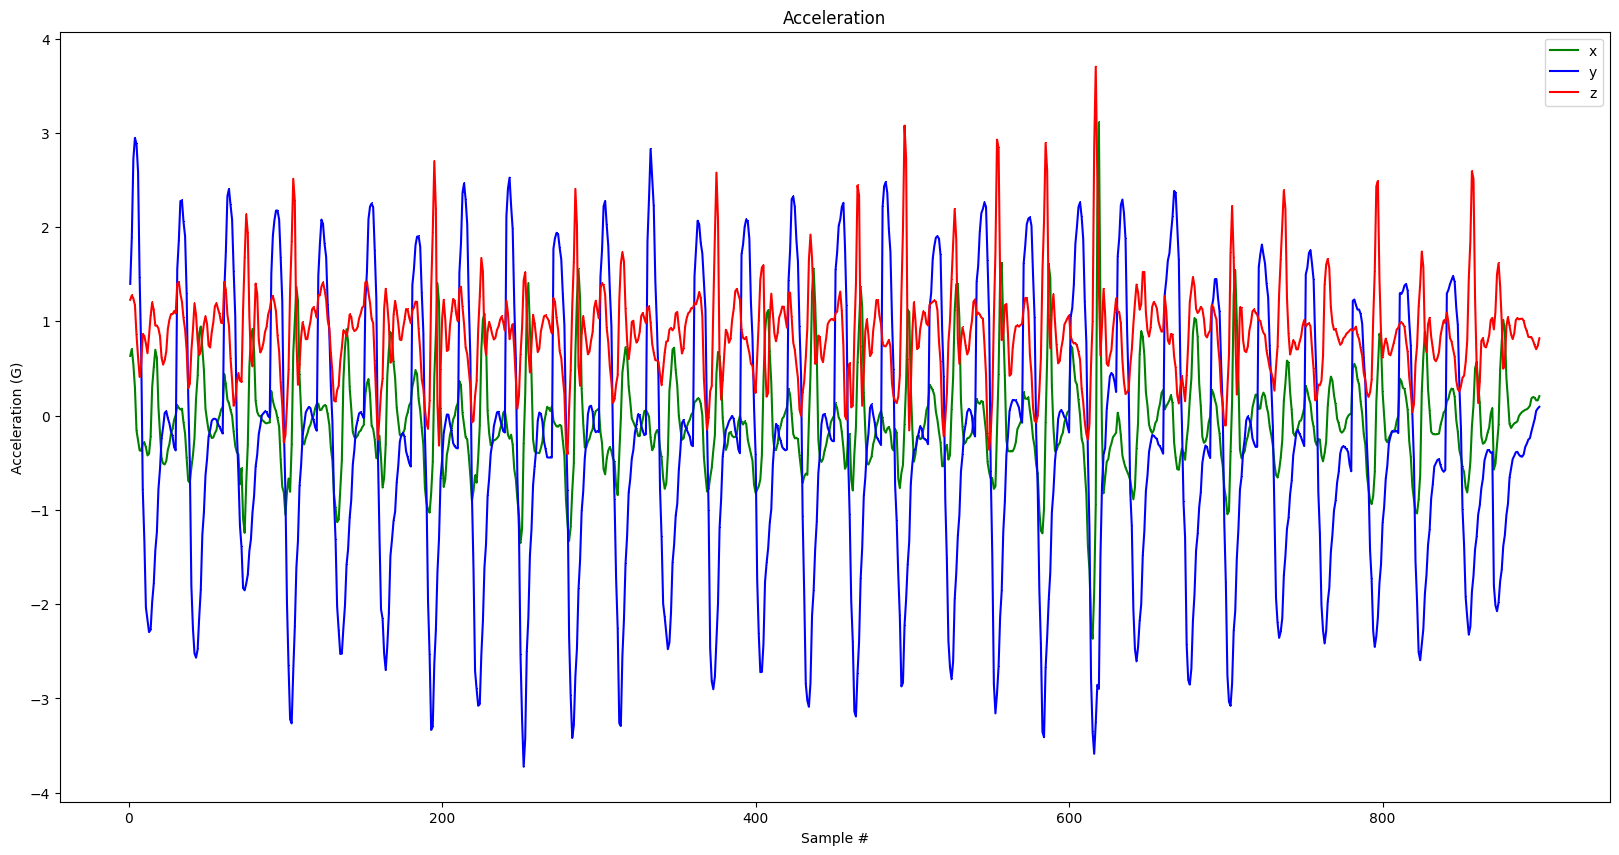

<ipython-input-1-f4549dee72d7>:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-1-f4549dee72d7>:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-1-f4549dee72d7>:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')


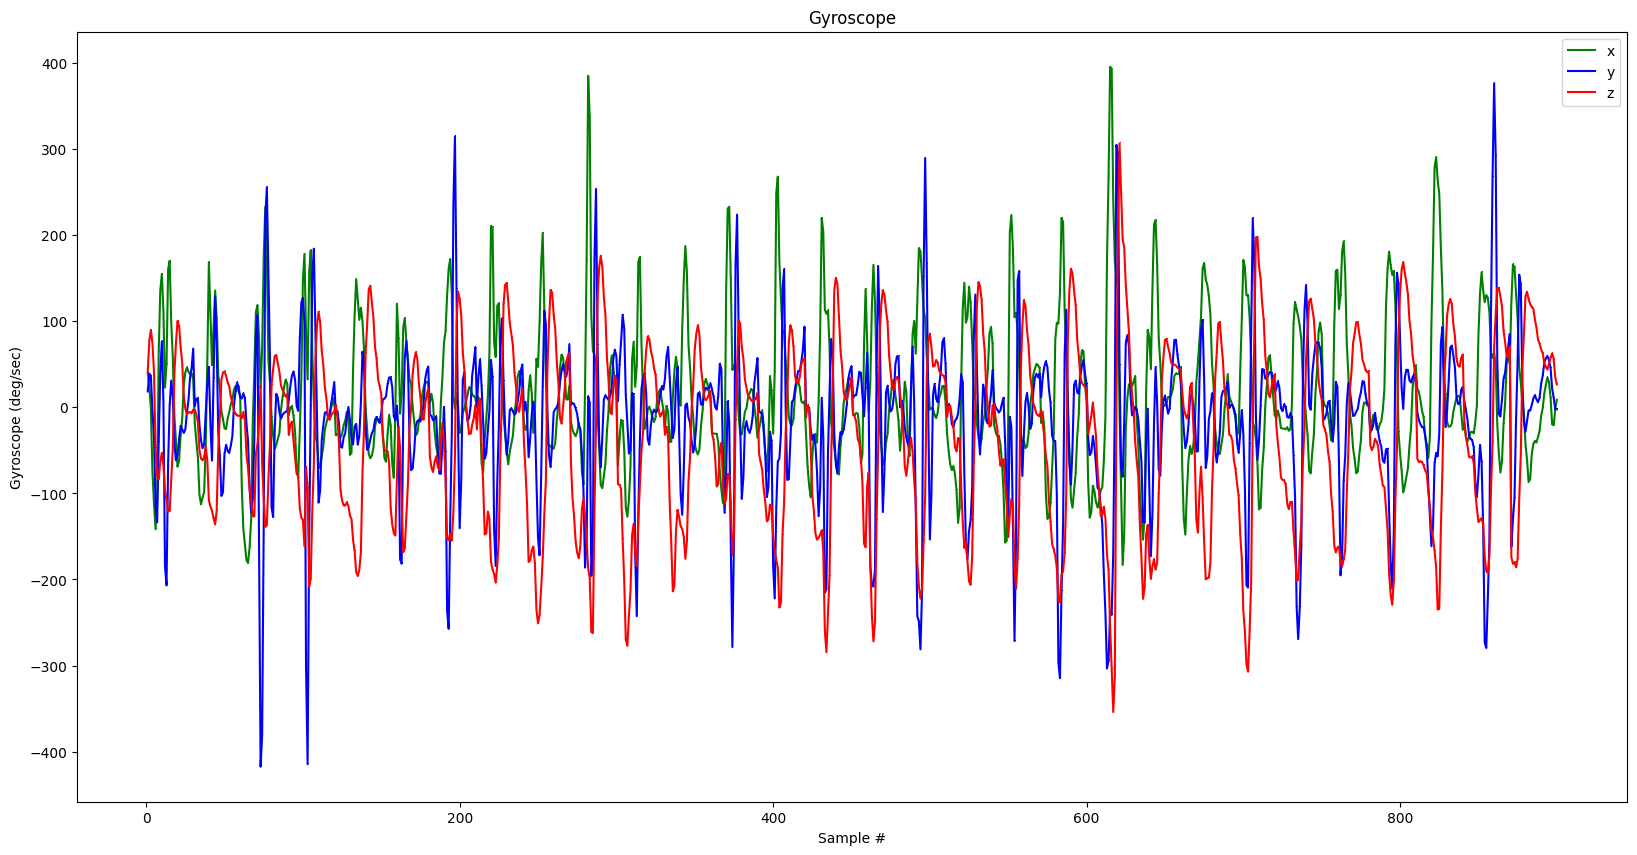

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "front.csv"

df = pd.read_csv("/content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()


# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "back",
    "down",
    "front",
    "left",
    "right",
    "rotate",
    "up"
]

CAPTURE_SAMPLES = 30
EXTRA_SAMPLES = 5
SAMPLES_PER_GESTURE = 20

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("/content/" + gesture + ".csv")

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / CAPTURE_SAMPLES)


  count = 0
  for i in range(num_recordings):
    tensor = []

    for j in range(CAPTURE_SAMPLES - SAMPLES_PER_GESTURE + 1):
      for k in range(SAMPLES_PER_GESTURE):
        index = i * CAPTURE_SAMPLES + j + k
        # normalize the input data, between 0 to 1:
        # - acceleration is between: -4 to +4
        # - gyroscope is between: -2000 to +2000
        tensor += [
            (df['aX'][index] + 4) / 8,
            (df['aY'][index] + 4) / 8,
            (df['aZ'][index] + 4) / 8,
            (df['gX'][index] + 2000) / 4000,
            (df['gY'][index] + 2000) / 4000,
            (df['gZ'][index] + 2000) / 4000
        ]

      inputs.append(tensor)
      outputs.append(output)
    count+=1
    '''
    for j in range(SAMPLES_PER_GESTURE):
      index = i * CAPTURE_SAMPLES + j + EXTRA_SAMPLES
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)
    count+=1
    '''

  print(f"\tThere are {count} recordings of the {gesture} gesture.")
# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.8.0-rc1

Processing index 0 for gesture 'back'.
	There are 30 recordings of the back gesture.
Processing index 1 for gesture 'down'.
	There are 30 recordings of the down gesture.
Processing index 2 for gesture 'front'.
	There are 30 recordings of the front gesture.
Processing index 3 for gesture 'left'.
	There are 30 recordings of the left gesture.
Processing index 4 for gesture 'right'.
	There are 30 recordings of the right gesture.
Processing index 5 for gesture 'rotate'.
	There are 30 recordings of the rotate gesture.
Processing index 6 for gesture 'up'.
	There are 30 recordings of the up gesture.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [ ]:
batch_size = 16
learning_rate = 1e-3
epochs = 50
inputs_dims = inputs_train.shape[1]

In [ ]:
# build the model and train it
model = tf.keras.Sequential()
#model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=inputs_dims)) # relu is used for performance
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(64, activation='relu', input_dim=inputs_dims))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(16, activation='relu', input_dim=64))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax', input_dim=16)) # softmax is used, because we only expect one gesture to occur per input
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=epochs, batch_size=batch_size, validation_data=(inputs_validate, outputs_validate))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                84544     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 16)                1040      
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 7)                 119       
                                                                 
Total params: 85,703
Trainable params: 85,703
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


87/87 [==============================] - 2s 9ms/step - loss: 1.8061 - accuracy: 0.2857 - val_loss: 1.5804 - val_accuracy: 0.5000
Epoch 2/50
87/87 [==============================] - 1s 7ms/step - loss: 1.4206 - accuracy: 0.4473 - val_loss: 1.1431 - val_accuracy: 0.5844
Epoch 3/50
87/87 [==============================] - 1s 8ms/step - loss: 1.1460 - accuracy: 0.5657 - val_loss: 0.8407 - val_accuracy: 0.8030
Epoch 4/50
87/87 [==============================] - 1s 6ms/step - loss: 0.9434 - accuracy: 0.6804 - val_loss: 0.7427 - val_accuracy: 0.8571
Epoch 5/50
87/87 [==============================] - 1s 6ms/step - loss: 0.8260 - accuracy: 0.7208 - val_loss: 0.6073 - val_accuracy: 0.7641
Epoch 6/50
87/87 [==============================] - 0s 4ms/step - loss: 0.7220 - accuracy: 0.7540 - val_loss: 0.4714 - val_accuracy: 0.9610
Epoch 7/50
87/87 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 0.8001 - val_loss: 0.3995 - val_accuracy: 0.9481
Epoch 8/50
87/87 [=============

## Verify

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

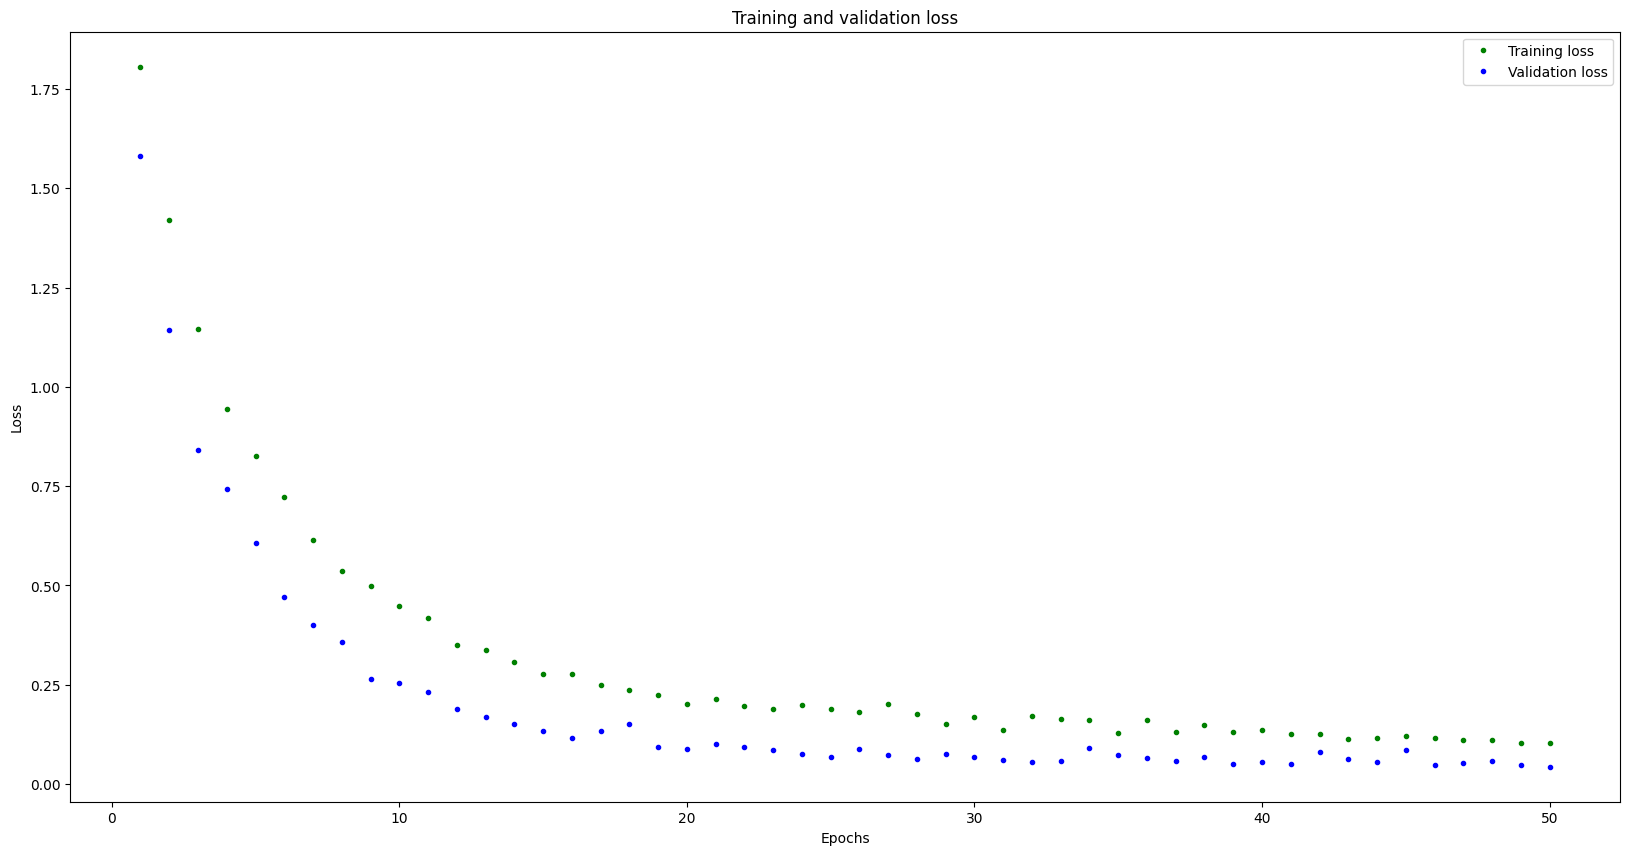

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



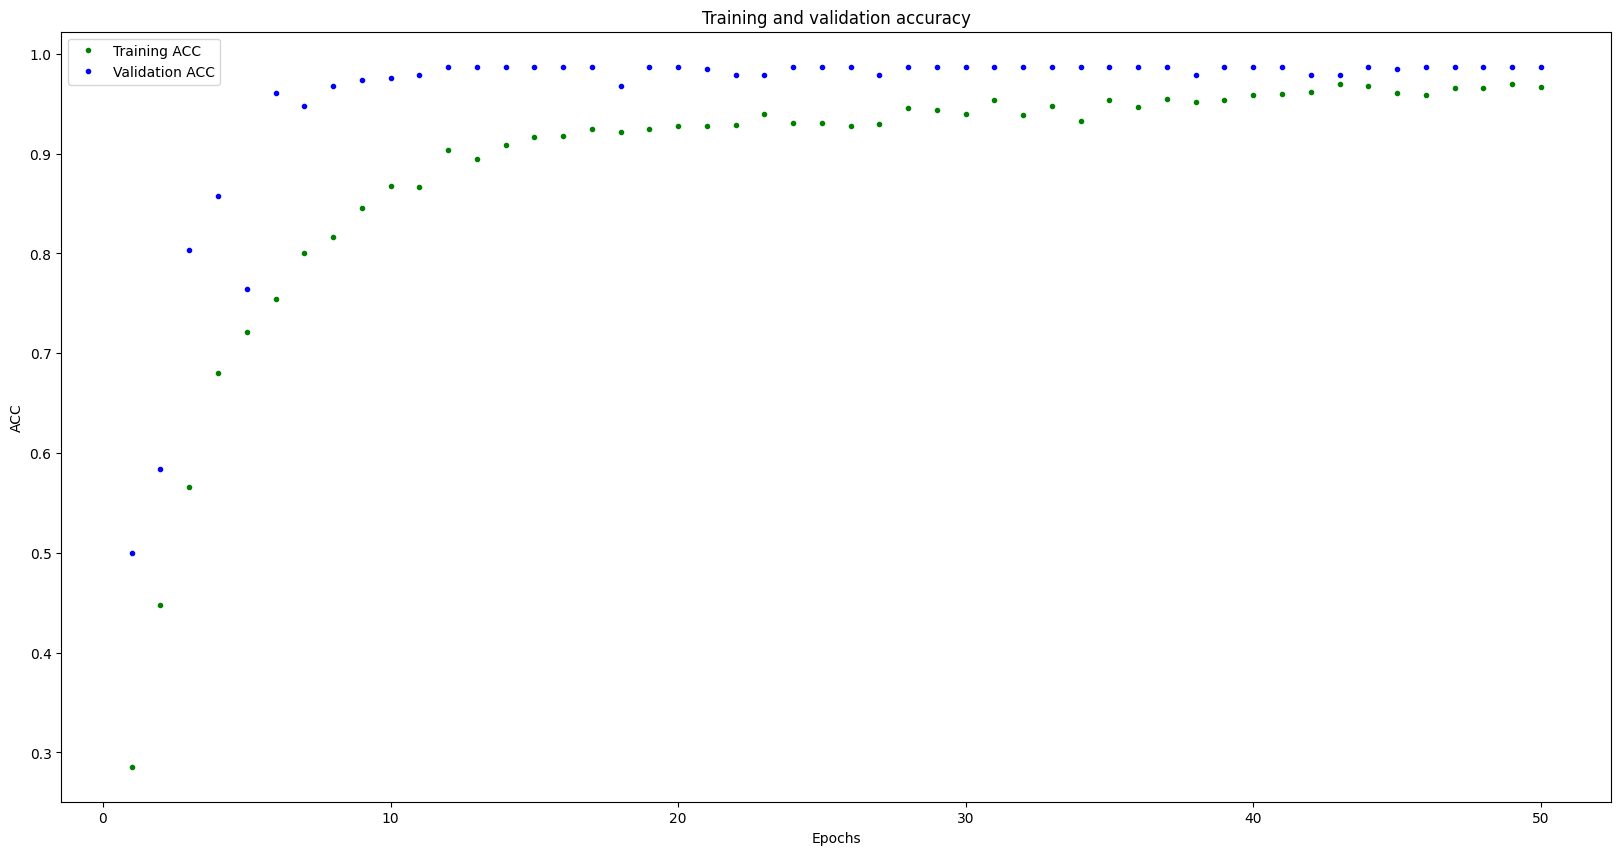

In [ ]:
# graph of mean absolute error
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'g.', label='Training ACC')
plt.plot(epochs, val_acc, 'b.', label='Validation ACC')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()


### Run with Test Data
Put our test data into the model and plot the predictions


In [ ]:
from sklearn.metrics import accuracy_score

predictions = model.predict(inputs_test)

# Convert predictions to class labels (assuming outputs_test are one-hot encoded)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(outputs_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(actual_classes, predicted_classes)

# Print the predictions and the expected outputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)
print("predicted classes =\n", predicted_classes)
print("actual classes =\n", actual_classes)
print(f'Accuracy: {accuracy:.4f}')

# Plot the predictions along with to the test data
'''
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test.argmax(axis=1), 'b.', label='Actual')
plt.plot(inputs_test, predictions.argmax(axis=1), 'r.', label='Predicted')
plt.show()
'''

predictions =
 [[0.997 0.    0.    ... 0.    0.    0.002]
 [0.    0.    0.    ... 0.    1.    0.   ]
 [0.    0.    0.    ... 1.    0.    0.   ]
 ...
 [1.    0.    0.    ... 0.    0.    0.   ]
 [0.007 0.001 0.    ... 0.019 0.001 0.974]
 [0.    0.    0.    ... 0.    1.    0.   ]]
actual =
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
predicted classes =
 [0 5 4 6 5 0 0 4 3 2 0 0 1 6 4 1 4 6 1 1 3 5 3 3 0 1 5 4 3 6 1 6 0 6 0 3 3
 2 0 6 3 5 2 6 4 4 5 2 4 2 3 2 5 0 2 0 3 3 3 5 4 4 1 1 3 5 4 5 2 1 3 2 6 3
 1 5 3 1 0 6 5 0 6 3 5 5 1 1 4 0 4 5 2 1 1 0 5 5 4 4 1 2 1 3 0 1 2 0 3 6 3
 6 4 5 1 5 2 0 2 4 0 0 3 2 5 0 1 4 6 3 4 1 0 2 0 5 1 4 1 2 1 1 5 3 0 6 1 0
 1 3 2 4 0 0 0 1 4 5 6 1 5 1 3 6 1 4 0 4 2 3 4 5 1 5 3 3 1 2 0 2 0 2 2 1 1
 3 6 5 5 1 5 5 0 0 4 1 6 6 4 5 6 2 6 1 5 2 3 6 2 3 6 1 2 3 3 1 0 0 4 1 1 4
 0 2 5 6 0 3 1 2 0 4 1 5 6 3 6 1 6 0 2 1 6 3 2 0 1 3 5 2 6 3 0 1 0 5 6 2 2
 3 1 2 3 

"\nplt.clf()\nplt.title('Training data predicted vs actual values')\nplt.plot(inputs_test, outputs_test.argmax(axis=1), 'b.', label='Actual')\nplt.plot(inputs_test, predictions.argmax(axis=1), 'r.', label='Predicted')\nplt.show()\n"

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:

# Convert the model to the TensorFlow Lite format without quantization
def representative_dataset():
    for data in inputs[:1000]:  # Use a small portion of the test data
        yield [data.astype(np.float32)]
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset
tflite_model = converter.convert()


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [ ]:
import pathlib
# Save the model to disk

gesture_model = pathlib.Path("gesture_model.tflite")
gesture_model.write_bytes(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Model is 88232 bytes


In [ ]:
!apt-get update && apt-get -qq install xxd
#!xxd -i /content/gesture_model.tflite > model.cc
#!echo -ne "#include \"model_data_quant.h\"\nalignas(8)\n" > model_data_quant.cc
#!cat model.cc >> model_data_quant.h
#!sed -i -E 's/(unsigned\s.*\s).*(_len|\[\])/const \1model\2/g' model_data_quant.h

!xxd -i /content/gesture_model.tflite > model.h
!cat model.h

串流輸出內容已截斷至最後 5000 行。
  0xf8, 0xe7, 0x0f, 0x14, 0x03, 0xf7, 0xfb, 0x00, 0x0a, 0xf6, 0xfb, 0x04,
  0x09, 0xf8, 0x0e, 0x0a, 0x03, 0x12, 0x04, 0x04, 0x19, 0x0e, 0xf2, 0x0f,
  0xf3, 0x0d, 0x1c, 0x05, 0xf5, 0xf7, 0xfe, 0x24, 0xfc, 0x03, 0x0a, 0xf9,
  0x04, 0xf2, 0x0c, 0xff, 0x0b, 0xff, 0x0e, 0xfe, 0x01, 0xf8, 0x03, 0xfd,
  0xec, 0x11, 0x07, 0x14, 0x03, 0xef, 0x05, 0xfd, 0xfe, 0x10, 0xf2, 0xfc,
  0x09, 0x0b, 0xfe, 0x10, 0xf9, 0xfa, 0x01, 0xec, 0xef, 0xfa, 0xf8, 0x05,
  0x13, 0xfd, 0xfb, 0x02, 0xee, 0x0d, 0xff, 0xfd, 0x07, 0xf2, 0xfa, 0xf0,
  0xf0, 0x01, 0xf8, 0x07, 0x13, 0xff, 0xf2, 0x08, 0xf1, 0xff, 0xfb, 0xef,
  0xf0, 0xfb, 0x05, 0x12, 0x0c, 0x0d, 0x00, 0xf1, 0x0c, 0xff, 0x00, 0xff,
  0x08, 0x07, 0xf9, 0x08, 0xef, 0xf1, 0x02, 0x00, 0xf2, 0x0f, 0x0c, 0xee,
  0x02, 0xf1, 0x0c, 0xf5, 0xfe, 0x07, 0xfe, 0xef, 0xff, 0x05, 0x08, 0xf2,
  0x06, 0xfa, 0x05, 0xf0, 0x0e, 0xed, 0xfe, 0x00, 0xfb, 0x11, 0xf3, 0xfb,
  0xfc, 0xed, 0x04, 0x05, 0xfd, 0xfc, 0x00, 0x11, 0x13, 0x0f, 0xfb, 0xfb,
  0x11, 0x11, 0xe

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, inputs_test_indices):
  global inputs_test
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(inputs_test_indices),), dtype=int)
  for i, inputs_test_index in enumerate(inputs_test_indices):
    inputs_test_each = inputs_test[inputs_test_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.int8:
      input_scale, input_zero_point = input_details["quantization"]
      if(i == 0):
        print(input_scale)
        print(input_zero_point)
      inputs_test_each = inputs_test_each / input_scale + input_zero_point


    inputs_test_each = np.expand_dims(inputs_test_each, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], inputs_test_each)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    print(output)
    predictions[i] = output.argmax()

  return predictions

In [ ]:
import matplotlib.pylab as plt

# Change this to test a different image
inputs_test_index = range(inputs_test.shape[0])

## Helper function to test the models on one image
def test_model(tflite_file, inputs_test_index, model_type):
  global test_labels
  predictions = run_tflite_model(tflite_file, inputs_test_index)
  print(predictions)
  ground_Y = [ ground.argmax() for ground in outputs_test]
  accuracy = (np.sum(ground_Y== predictions) * 100) / len(inputs_test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(inputs_test)))


In [ ]:
test_model("/content/gesture_model.tflite", inputs_test_index, model_type="Quantized")

0.003921568859368563
-128
[ 127 -128 -128 -128 -128 -128 -127]
[-128 -128 -128 -128 -128  127 -128]
[-128 -128 -128 -128  127 -128 -128]
[-128 -128 -128 -128 -126 -128  125]
[-128 -128 -128 -128 -128  127 -128]
[ 127 -128 -128 -128 -128 -128 -128]
[ 127 -128 -128 -128 -128 -128 -128]
[-128 -128 -128 -128  127 -128 -128]
[-128 -128 -128  127 -128 -128 -128]
[-128 -128  127 -128 -128 -128 -128]
[ 127 -128 -128 -128 -128 -128 -128]
[ 127 -128 -128 -128 -128 -128 -128]
[-128  122 -122 -128 -128 -128 -128]
[-128 -128 -128 -128 -127 -128  126]
[-128 -128 -128 -128  127 -128 -128]
[-128  125 -125 -128 -128 -128 -128]
[-128 -128 -128 -128  127 -128 -128]
[-128 -128 -128 -128 -127 -128  126]
[-128  122 -122 -128 -128 -128 -128]
[-128  123 -124 -128 -128 -128 -128]
[-128 -128 -128  127 -128 -128 -128]
[-128 -128 -128 -128 -128  127 -128]
[-128 -128 -128  127 -128 -128 -128]
[-128 -128 -128  127 -128 -128 -128]
[ 127 -128 -128 -128 -128 -128 -128]
[-128  120 -121 -128 -128 -128 -128]
[-128 -128 -

## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
'''
!echo "const unsigned char model[] = {" > /content/model_quant.h
!cat gesture_model.tflite | xxd -i      >> /content/model_quant.h
!echo "};"                              >> /content/model_quant.h

import os
model_h_size = os.path.getsize("model_quant.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")
'''

'\n!echo "const unsigned char model[] = {" > /content/model_quant.h\n!cat gesture_model.tflite | xxd -i      >> /content/model_quant.h\n!echo "};"                              >> /content/model_quant.h\n\nimport os\nmodel_h_size = os.path.getsize("model_quant.h")\nprint(f"Header file, model.h, is {model_h_size:,} bytes.")\nprint("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")\n'

# Classifying IMU Data

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
